# Imports

In [1]:
import pandas as pd
import numpy as np 
from multiprocessing import Pool
import matplotlib.pyplot as plt
import seaborn as sns
import os
from outer_function_daily import outer_function
from functools import partial
from tqdm.notebook import tqdm
import tensorflow as tf
from rois import rois_func, portfolio_weights
import decimal
import plotly.express as px
from sklearn.metrics import r2_score
from tensorflow_addons.metrics import RSquare
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split

c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\brarn\anaconda3\envs\tensorflow\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an is

# Hyperparameters

In [2]:
model_name = 5
NUMBER_OF_RATES = 10

In [3]:
# Load the CSV file
df = pd.read_csv("results\overview\model results.csv")

# Filter the DataFrame for the given model number
model_data = df[df['model name'] == model_name]

# Extract the required data
NUMBER_OF_LINES = model_data['lines'].iloc[0]
NUMBER_OF_YEARS_TO_CONSIDER = model_data['years'].iloc[0]
BATCH_SIZE =  model_data['batch size'].iloc[0]

# Process the features column
features = model_data['features'].iloc[0].strip('[]').split()
cats_subset = []
features_subset = []

for feature in features:
    if feature == 'sectors':
        cats_subset.append(feature)
    else:
        features_subset.append(feature)

# Read data

In [4]:
# Import data
stocks_df = pd.read_csv("data/price.csv")

# Set date-time index
stocks_df['Date'] = pd.to_datetime(stocks_df["Date"], format='%Y-%m-%d')
stocks_df = stocks_df.set_index(stocks_df['Date'])
stocks_df = stocks_df.drop(columns = ["Date"])

# Drop all columns which only contain nan values
boolean = []
for stock in stocks_df.columns:
    boolean.append(not stocks_df[stock].isnull().all())
stocks_df = stocks_df.iloc[:, boolean]

stocks_df

,A,AA,AAL,AAP,AAPL,ABBV,ABNB,ABT,ACGL,ACHC,...,YUM,Z,ZBH,ZBRA,ZG,ZI,ZION,ZM,ZS,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-02,NaN,3.217068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,3.187954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-07,NaN,3.246180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,3.289852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-04,128.880005,26.809999,13.35,55.630001,189.429993,144.149994,133.699997,105.190002,81.989998,74.750000,...,125.650002,44.090000,116.889999,239.369995,42.330002,14.71,38.680000,68.160004,198.259995,182.119995
2023-12-05,127.879997,25.240000,13.13,53.160000,193.419998,144.570007,133.710007,104.349998,81.849998,74.209999,...,124.379997,44.290001,115.820000,234.360001,42.520000,14.48,37.389999,68.720001,198.910004,179.649994
2023-12-06,128.910004,25.120001,13.48,55.160000,192.320007,146.380005,135.309998,104.940002,79.970001,71.150002,...,124.809998,45.090000,116.129997,234.130005,43.490002,15.50,37.150002,70.940002,197.910004,182.000000


In [5]:
# Read data
cat_variables = pd.read_csv("data/categorical.csv")
cat_variables = cat_variables.set_index("Unnamed: 0")
cat_variables = cat_variables.rename_axis(None, axis = 0)
cat_variables = cat_variables.dropna(axis="columns")

# Drop stocks such that the remaining stocks are those in both cat_variables and stocks_df
intersection = list(set(stocks_df.columns) & set(cat_variables.columns))
cat_variables = cat_variables[intersection]
stocks_df = stocks_df[intersection]

cat_variables

,DG,PH,EVR,PLD,CI,GH,IPGP,ZM,APD,CSGP,...,DVN,NYT,CGNX,EHC,G,WBD,CE,UHAL,RYN,NNN
sectors,Consumer Discretionary,Industrials,Financials,Real Estate,Health Care,Health Care,Information Technology,Information Technology,Materials,Industrials,...,Energy,Communication Services,Information Technology,Health Care,Information Technology,Communication Services,Materials,Industrials,Real Estate,Real Estate


In [6]:
# Get unique categories for each categorical variable
cats_df = pd.DataFrame()
for cat in cat_variables.index:
    uniques = list(cat_variables.loc[cat, :].unique())
    categories = np.sort(uniques)
    cats_df[cat] = categories

cats_df

,sectors
0,Communication Services
1,Consumer Discretionary
2,Consumer Staples
3,Energy
4,Financials
5,Health Care
6,Industrials
7,Information Technology
8,Information technology
9,Materials


In [7]:
# Read data
features_daily = pd.read_csv("data/features.csv")
features_daily['Date'] = pd.to_datetime(features_daily["Date"], format='%Y-%m-%d')
features_daily = features_daily.set_index("Date")
features_daily = features_daily.dropna()

# Make names smaller to use in file names
print(features_daily.columns)
features_daily.columns = ['BCI', 'CCI', 'CLI', '3m %', 'Broad $', 'Construction', 'Consumer prices', 'Manu $',
       'Indu production', 'Long %', 'MCI', 'Narrow $', 'Overnight %', 'Cars', 'producer $', 'Retail volume',
       'Total employment', 'Total manu']

features_daily

Index(['BCI', 'CCI', 'CLI', '3 month interbank rate', 'Broad money',
       'Construction', 'Consumer prices', 'Manufacturing hourly earnings',
       'Industrial production', 'Long-term interest rate',
       'Manufacturing confidence indicator', 'Narrow money',
       'Overnight interbank rate', 'Car registrations',
       'Manufacturing producer prices', 'Retail trade volume',
       'Total employment', 'Total manufacturing'],
      dtype='object')


,BCI,CCI,CLI,3m %,Broad $,Construction,Consumer prices,Manu $,Indu production,Long %,MCI,Narrow $,Overnight %,Cars,producer $,Retail volume,Total employment,Total manu
Date,,,,,,,,,,,,,,,,,,
1990-01-01,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-02,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-03,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-04,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
1990-01-05,98.82303,100.6509,99.79321,8.16,26.291189,40.385124,53.751419,52.855468,61.105826,8.21,-5.6,26.324891,8.23,138.407385,60.738345,67.509220,119081.0,61.244983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-24,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796
2022-12-25,98.91054,97.0624,98.88888,4.51,177.318578,164.796803,125.221820,128.973371,100.598801,3.62,-3.2,655.997485,4.10,37.603772,131.749933,118.300105,159244.0,97.682796


In [8]:
# Convert to a numpy array for speedy opterations later on
stocks_np = stocks_df.to_numpy()

# Convert to a numpy array for speedy opterations later on
cat_variables_np = cat_variables.to_numpy()

# Convert to a numpy array for speedy opterations later on
features_daily_np = features_daily.to_numpy()

# Create data

In [9]:
# Sort for consistency in file names and such
cats_subset.sort()
features_subset.sort()

# Indexes of features columns in df to be used to find corresponding columns in numpy
def get_feature_index(feature):
    return list(features_daily.columns).index(feature)
def get_cat_index(cat):
    return list(cat_variables.index).index(cat)

cats_subset_indexes = []
for var in cats_subset:
    cats_subset_indexes.append(get_cat_index(var))

features_subset_indexes = []
for var in features_subset:
    features_subset_indexes.append(get_feature_index(var))



p = Pool(os.cpu_count())
first_index = NUMBER_OF_YEARS_TO_CONSIDER*365+1 # `+1` needed since slicing is end-exclusive
range_iterations = range(first_index, len(stocks_np) - 365)

iterations = tqdm(range_iterations,
                    desc=f"Working on Dataset: {NUMBER_OF_LINES} lines, {NUMBER_OF_YEARS_TO_CONSIDER} years",
                    disable=False)

result_list = p.map(partial(outer_function,
                            stocks_np = stocks_np,
                            NUMBER_OF_YEARS_TO_CONSIDER = NUMBER_OF_YEARS_TO_CONSIDER,
                            NUMBER_OF_LINES = NUMBER_OF_LINES,
                            features_subset_indexes = features_subset_indexes,
                            features_np = features_daily_np,
                            cats_np = cat_variables_np,
                            cats_index = cats_subset_indexes,
                            cats_df = cats_df,
                            dates = np.array(stocks_df.index),
                            stocks = np.array(stocks_df.columns)
                            ),
                    iterations)

data = np.vstack([result[0] for result in result_list])
data_dates = np.hstack([result[1] for result in result_list])
data_stocks = np.hstack([result[2] for result in result_list])

cats_dict = dict()
for k in cats_subset_indexes:
    cats_dict[k] = np.hstack([result_list[i][3][k] for i in range(len(result_list))])

features_dict = dict()
for k in features_subset_indexes:
    features_dict[k] = np.vstack([result_list[i][4][k] for i in range(len(result_list))])

categorical_dummy_dfs_list = []
for c in cats_subset_indexes:
    categorical_dummy_dfs_list.append(pd.get_dummies(cats_dict[c]).iloc[:,:-1])

# The `data` list must go last since the rest of the script expects the dependent variable to be the last column !!
model_data = np.hstack(categorical_dummy_dfs_list + [features_dict[f] for f in features_subset_indexes] + [data])

# Create data for model
tuples = list(zip(data_dates, data_stocks))
index = pd.MultiIndex.from_tuples(tuples, names=["dates", "stocks"])
model_data = pd.DataFrame(model_data, index=index)

# Split the data into 60% train and 40% for the combined test and validation sets (the test data won't be used in this notebook.)
x_train, x_temp, y_train, y_temp = train_test_split(model_data.iloc[:,:-1], model_data.iloc[:,-1], test_size=0.4, random_state=42, shuffle=False)

# Split the temp data into test and validation sets (50% each of the temp data)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)
test_dates = x_test.index

Working on Dataset: 36 lines, 2 years:   0%|          | 0/9983 [00:00<?, ?it/s]

# Testing

1579/1579 [==============================] - 3s 1ms/step


Trying different rates:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.1:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.2:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.3:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.4:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.5:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.6:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.7:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.8:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 0.9:   0%|          | 0/10 [00:00<?, ?it/s]

Getting rois for rate: 1.0:   0%|          | 0/10 [00:00<?, ?it/s]

2631/2631 [==============================] - 3s 890us/step


Getting portfolio rois:   0%|          | 0/9983 [00:00<?, ?it/s]

Creating interactive scatterplot
Saving interactive scatterplot
Saved interactive scatterplot


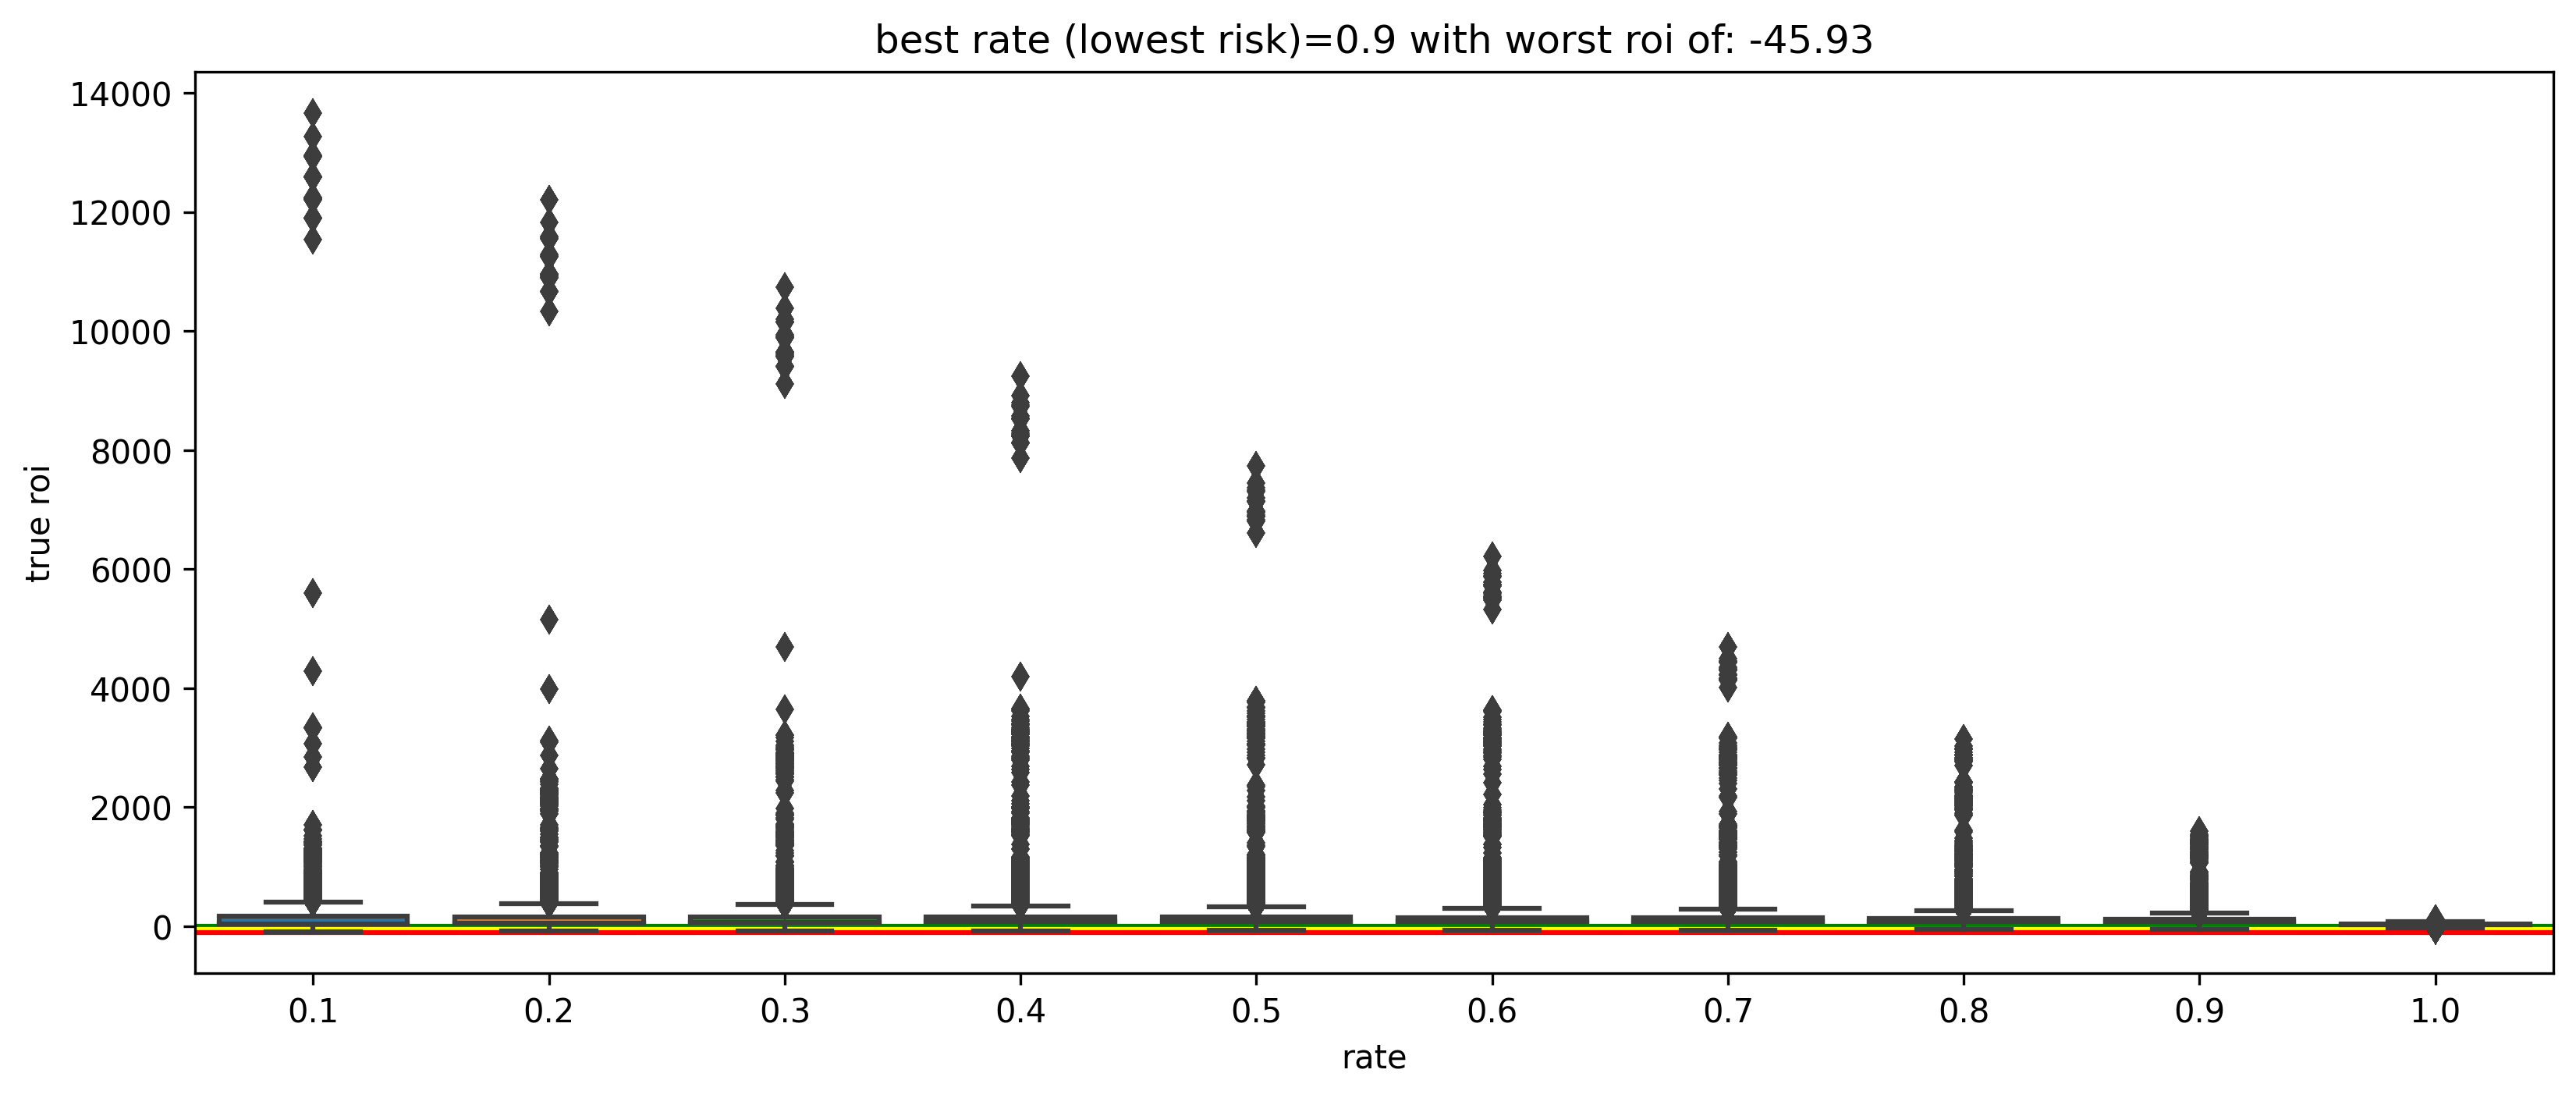

In [11]:
model_path = f"results/details/models/{model_name}.h5"
model = tf.keras.models.load_model(model_path)

# Portfolio creation
x_train_dates = [i[0] for i in x_train.index]
x_train_stock = [i[1] for i in x_train.index]
train_predictions = model.predict(x_train, batch_size=BATCH_SIZE)
portfolio_data = np.array([x_train_dates,
                            x_train_stock,
                            x_train.iloc[:,-1],
                            y_train.values,
                            train_predictions[:,0]]
                            )
portfolio_data = pd.DataFrame(portfolio_data.T,
                                columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

portfolio_data = portfolio_data.set_index("date")
portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])

rois_data = []
pbar2 = tqdm(np.linspace(0,1,NUMBER_OF_RATES+1)[1:], desc="Trying different rates", total=NUMBER_OF_RATES)
for rate in pbar2:
    rate = np.round(rate,3)
    tups = []
    for i in range(NUMBER_OF_RATES):
        tups.append((rate, portfolio_data))
    tups_tqdm = tqdm(tups, desc=f"Getting rois for rate: {rate}", total=len(tups))
    rois = p.map(rois_func, tups_tqdm)
    rois_data.append(np.vstack(rois))
pbar2.close()

rois_data = np.vstack(rois_data)
rois_data = pd.DataFrame(rois_data, columns=["rate", "true roi", "expected roi", "num unique stocks"])
# Drop nan rows as those represent times when all stocks were expected to go down
rois_data = rois_data.dropna()

best_rate = rois_data[["true roi", "rate"]].groupby(["rate"]).min().idxmax(axis="rows")[0]
best_rate_min_roi = rois_data[["true roi", "rate"]].groupby(["rate"]).min().max(axis="rows")[0]

plt.figure(figsize=(13, 5), dpi=300)

# We are only going to invest when we expect a positive roi so only consider those.
positive_rois_data = rois_data.loc[rois_data["expected roi"]>0,:]
plt.axhline(0, color="green")
plt.axhline(-50, color="yellow")
plt.axhline(-100, color="red")
sns.boxplot(data=positive_rois_data, x="rate", y="true roi") # , showfliers = False
plt.title(f"best rate (lowest risk)={best_rate} with worst roi of: {round(best_rate_min_roi,2)}")


# Portfolio creation - interactive plot for testing data
features_dates = [i[0] for i in model_data.iloc[:,:-1].index]
features_stock = [i[1] for i in model_data.iloc[:,:-1].index]
features_predictions = model.predict(model_data.iloc[:,:-1], batch_size=BATCH_SIZE)
portfolio_data = np.array([features_dates,
                            features_stock,
                            model_data.iloc[:,:-1].iloc[:,-1],
                            model_data.iloc[:,-1].values,
                            features_predictions[:,0]]
                            )
portfolio_data = pd.DataFrame(portfolio_data.T,
                                columns = ["date", "stock", "current price", "true 1 year", "predicted 1 year"])

portfolio_data = portfolio_data.sort_values(by=["date", "predicted 1 year"], ascending=[True, False])
portfolio_data = portfolio_data.set_index("date")
port_index = portfolio_data.index.unique()

port_index_tqdm = tqdm(enumerate(port_index), desc="Getting portfolio rois", total=len(port_index))
rois = np.zeros((len(port_index),2))
extra_data = []
for i, date in port_index_tqdm:
    if date in test_dates:
        dataset_string = "test"
    else:
        dataset_string = "train"

    # filter out relevant rows
    current_df = portfolio_data.loc[date,:]

    # Get array containing expected roi for each stock
    expected_roi_per_stock = ((current_df["predicted 1 year"].values - current_df["current price"].values)/current_df["current price"].values)*100
    current_df["expected roi"] = expected_roi_per_stock

    current_df = current_df.sort_values(["expected roi"], ascending=False)
    current_prices = current_df["current price"]
    current_stocks = current_df["stock"]
    expected_roi_per_stock = current_df["expected roi"]

    weights, num_stocks = portfolio_weights(best_rate, expected_roi_per_stock)

    stocks_to_show = 10
    weights_string = " ".join(list([str(round(num, 2)) for num in list(weights)[:stocks_to_show]]))
    stocks_string = " ".join(list(current_stocks)[:stocks_to_show])
    current_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_prices)[:stocks_to_show]]))
    predicted_prices_string = " ".join(list([str(round(num, 2)) for num in list(current_df["predicted 1 year"])])[:stocks_to_show])
    expected_roi_string = " ".join(list([str(round(num, 2)) for num in list(expected_roi_per_stock)[:stocks_to_show]]))
    true_price_string = " ".join(list([str(round(num, 2)) for num in list(current_df["true 1 year"])[:stocks_to_show]]))

    current_portfolio_wealth = sum([weights[w] * decimal.Decimal(current_df["current price"][w]) for w in range(len(weights))])
    current_portfolio_wealth = float(current_portfolio_wealth)


    future_true_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "true 1 year"][w]) for w in range(len(weights))])
    future_true_wealth = float(future_true_wealth)


    future_predicted_wealth = sum([weights[w] * decimal.Decimal(current_df.loc[:, "predicted 1 year"][w]) for w in range(len(weights))])
    future_predicted_wealth = float(future_predicted_wealth)

    if not current_portfolio_wealth == 0:
        true_roi = ((future_true_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
        expected_roi = ((future_predicted_wealth-current_portfolio_wealth)/current_portfolio_wealth)*100
    else:
        # The nans represent days when no stocks were expected to increase in price after 1 year
        true_roi = np.nan
        expected_roi = np.nan

    rois[i, :] = np.array([true_roi, expected_roi])
    # Append data
    extra_data.append([stocks_string, current_prices_string, true_price_string, predicted_prices_string, expected_roi_string, num_stocks, weights_string, dataset_string])

rois_data = pd.DataFrame(rois, columns = ["true roi", "expected roi"], index=port_index)
extra_data = pd.DataFrame(extra_data,
                            columns = ["stocks", "current stock prices", "1Y true prices", "1Y predicted prices", "stocks expected roi", "num unique stocks", "weights", "dataset"],
                            index=port_index)
extra_data["date"] = [str(date.date()) for date in extra_data.index]

rois_data = pd.concat([rois_data, extra_data], axis="columns", ignore_index=False)
# Drop nan rows as those represent times when all stocks were expected to go down
rois_data = rois_data.dropna()

print("Creating interactive scatterplot")
r_squared_train = r2_score(rois_data.loc[rois_data.dataset == "train", "true roi"], rois_data.loc[rois_data.dataset == "train", "expected roi"])
r_squared_test = r2_score(rois_data.loc[rois_data.dataset == "test", "true roi"], rois_data.loc[rois_data.dataset == "test", "expected roi"])
fig = px.scatter(rois_data,
                    x="true roi", y="expected roi",
                    title = f"Train r2 = {round(r_squared_train,3)}, Test r2 = {round(r_squared_test,3)}",
                    hover_data=extra_data.columns,
                    marginal_x="box", marginal_y="box",
                    color = "dataset"
                    )
# Add a line trace with y=x to the figure
fig.add_trace(go.Scatter(x=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                            y=[rois_data["true roi"].min(), rois_data["true roi"].max()],
                            mode='lines',
                            name='y=x'))

print("Saving interactive scatterplot")
fig.write_html(f"results/best_model.html")
print("Saved interactive scatterplot")

The plot above is to determine a "rate" which is for essentially choosing how diverse our portfolio. Smaller rate means less diverse and higher rate means more diverse!